In [2]:
from __future__ import annotations

In [6]:
from collections import deque
from graphviz import Digraph
import math
import numpy as np

In [5]:
class Value:
    def __init__(self, data:float, label:str = "", 
                 parents:tuple[Value] = (), op: str = "",
                 _backward:function = lambda: None) -> None:
        self.data = data
        self.label = label
        self.parents = parents
        self.op = op
        self.grad = 0
        self._backward = _backward # calculates gradients of parents
        
    def backward(self) -> None:
        topological_sort = []
        visited = set()
        def build_topological_sort(node): # dfs
            if node not in visited:
                visited.add(node)
                for parent in node.parents:
                    build_topological_sort(parent)
                topological_sort.append(node) # post-order traversal
        build_topological_sort(self)
        
        self.grad = 1.0
        for node in reversed(topological_sort): # reversed post-order dfs -> topological
            node._backward()
        
    def backward_bfs_fucked(self) -> None: # bfs not topological: 2 unequal paths to same dest 
        self.grad = 1 # derivative with respect to itself
        
        visited = set()
        visit_queue = deque([self])
        while visit_queue:
            current_node = visit_queue.popleft()
            if current_node not in visited: # parent can have multiple kids
                print(current_node)
                current_node._backward()
                visit_queue.extend(current_node.parents)
                visited.add(current_node)    
    
    def __add__(self, other: Value) -> Value:
        out = Value(self.data + other.data, 
                    parents=(self, other), op="+")
        
        def _backward():
            self.grad += out.grad * 1 # accumulate gradients
            other.grad += out.grad * 1
        out._backward = _backward

        return out
    
    def __sub__(self, other: Value) -> Value:
        return self + (-other)
    
    def __mul__(self, other: Value) -> Value:
        out = Value(self.data * other.data, 
                    parents=(self, other), op="*")
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other: Value) -> Value:
        return self * other**-1
    
    def __neg__(self) -> Value:
        return self * Value(-1)
        
    def exp(self) -> Value:
        out = Value(math.exp(self.data),
                    parents=(self, ), op="exp")
        
        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        
        return out
    
    def __pow__(self, other: float) -> Value:
        out = Value(self.data ** other,
                    parents=(self, ), op=f"**{other}")
        
        def _backward():
            self.grad += out.grad * (other * self.data**(other-1))
        out._backward = _backward
        
        return out
    
    def tanh(self) -> Value:
        out = Value((math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1),
                    parents=(self, ), op="tanh")
        
        def _backward():
            self.grad += out.grad * (1 - out.data**2)
        out._backward = _backward
        
        return out
            
    def __repr__(self) -> str:
        return f"Value(label={self.label}, data={self.data})"
    
    def draw_graph(self) -> None:
        graph = Digraph(format="svg", graph_attr={"rankdir": "LR"})
        nodes: set[Value] = set()
        edges: set[Value] = set()
        visit_queue = deque([self])
        while visit_queue: # bfs to build
            current_node = visit_queue.popleft()
            if current_node not in nodes:
                for parent in current_node.parents:
                    edge = (parent, current_node)
                    edges.add(edge)
                nodes.add(current_node)
                visit_queue.extend(current_node.parents)
                
        for node in nodes:
            uid = str(id(node))
            graph.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (node.label, node.data, node.grad), shape="record")
            if node.op:
                graph.node(name=f"{uid}-{node.op}", label=node.op)
                graph.edge(f"{uid}-{node.op}", uid)
        for (n1, n2) in edges:
            graph.edge(str(id(n1)), f"{str(id(n2))}-{n2.op}")
        
        return graph

In [103]:
class Neuron:
    def __init__(self, input_size: int) -> None:
        self.w = [Value(rand_n) for rand_n in np.random.uniform(-1, 1, input_size)]
        self.b = Value(np.random.uniform(-1, 1))
        
    def __call__(self, x: list[Value]) -> Value:
        activation = sum([w_i * x_i for (w_i, x_i) in zip(self.w, x)],
                         self.b)
        return activation.tanh()
    
    def parameters(self) -> list[Value]:
        return self.w + [self.b]
        
class Layer:
    def __init__(self, input_size: int, layer_size: int) -> None:
        self.neurons = [Neuron(input_size) for _ in range(layer_size)]
        
    def __call__(self, x: list[Value]) -> list[Value]:
        return [neuron(x) for neuron in self.neurons]
    
    def parameters(self) -> list[Value]:
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params
    
class MLP:
    def __init__(self, input_size: int, layer_sizes: list[int]) -> None:
        size_info = [input_size] + layer_sizes
        self.layers = [Layer(size_info[i], size_info[i+1]) for i in range(len(layer_sizes))]
        
    def __call__(self, x: list[Value]) -> list[Value]:
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self) -> list[Value]:
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params
        

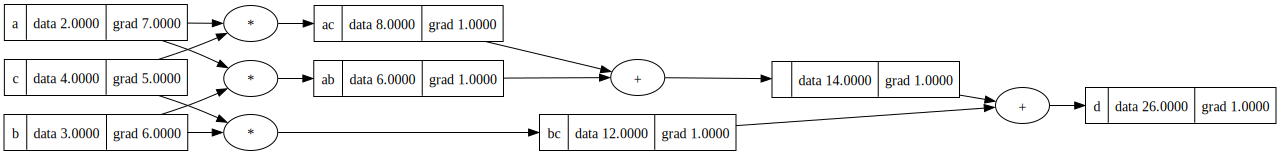

In [28]:
a = Value(2, label="a")
b = Value(3, label="b")
c = Value(4, label="c")
ab = a * b; ab.label = "ab"
ac = a * c; ac.label = "ac"
bc = b * c; bc.label = "bc"
d = ab + ac + bc; d.label = "d"
d.backward()
d.draw_graph()

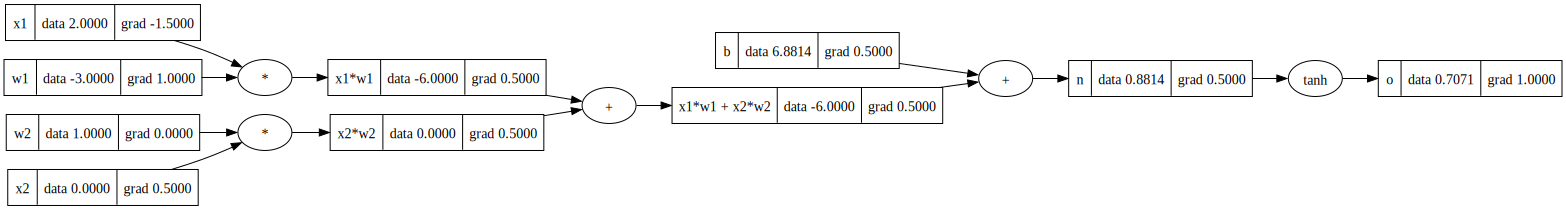

In [29]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
o.draw_graph()

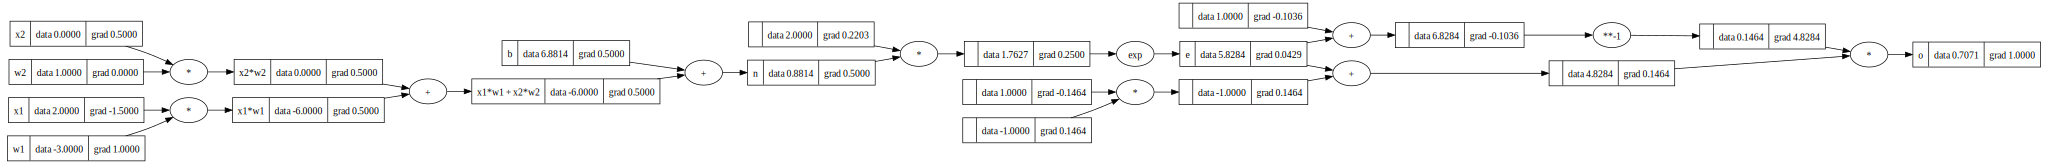

In [30]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (Value(2)*n).exp(); e.label = "e"
o = (e - Value(1)) / (e + Value(1)); o.label = 'o'
# ----
o.backward()
o.draw_graph()

In [125]:
xs = [
  [Value(2.0), Value(3.0), Value(-1.0)],
  [Value(3.0), Value(-1.0), Value(0.5)],
  [Value(0.5), Value(1.0), Value(1.0)],
  [Value(1.0), Value(1.0), Value(-1.0)]
]
ys = [Value(1.0), Value(-1.0), Value(-1.0), Value(1.0)] # desired targets

mlp = MLP(3, [4, 4, 1])
len(mlp.parameters()) # 3*4+4 + 4*4+4 + 4*1+1 = 41

41

In [126]:
loss: Value = None
for iteration in range(20):
  ypreds = [mlp(x)[0] for x in xs]
  loss = sum([(y-ypred)**2 for y, ypred in zip(ys, ypreds)], Value(0.0))
  
  print(f"ITERATION {iteration:2d}: LOSS = {loss.data:.3f}")
  
  # flushing gradients
  for param in mlp.parameters():
    param.grad = 1
  for x in xs:
    for x_i in x:
      x_i.grad = 0
  for y in ys:
    y.grad = 0
  loss.backward()
  
  for param in mlp.parameters():
    param.data -= 0.01 * param.grad
# loss.draw_graph()

# for i in range(20):
#   break

ITERATION  0: LOSS = 5.440
ITERATION  1: LOSS = 4.935
ITERATION  2: LOSS = 4.537
ITERATION  3: LOSS = 4.230
ITERATION  4: LOSS = 3.993
ITERATION  5: LOSS = 3.808
ITERATION  6: LOSS = 3.660
ITERATION  7: LOSS = 3.539
ITERATION  8: LOSS = 3.439
ITERATION  9: LOSS = 3.355
ITERATION 10: LOSS = 3.283
ITERATION 11: LOSS = 3.219
ITERATION 12: LOSS = 3.163
ITERATION 13: LOSS = 3.112
ITERATION 14: LOSS = 3.065
ITERATION 15: LOSS = 3.020
ITERATION 16: LOSS = 2.977
ITERATION 17: LOSS = 2.935
ITERATION 18: LOSS = 2.892
ITERATION 19: LOSS = 2.849


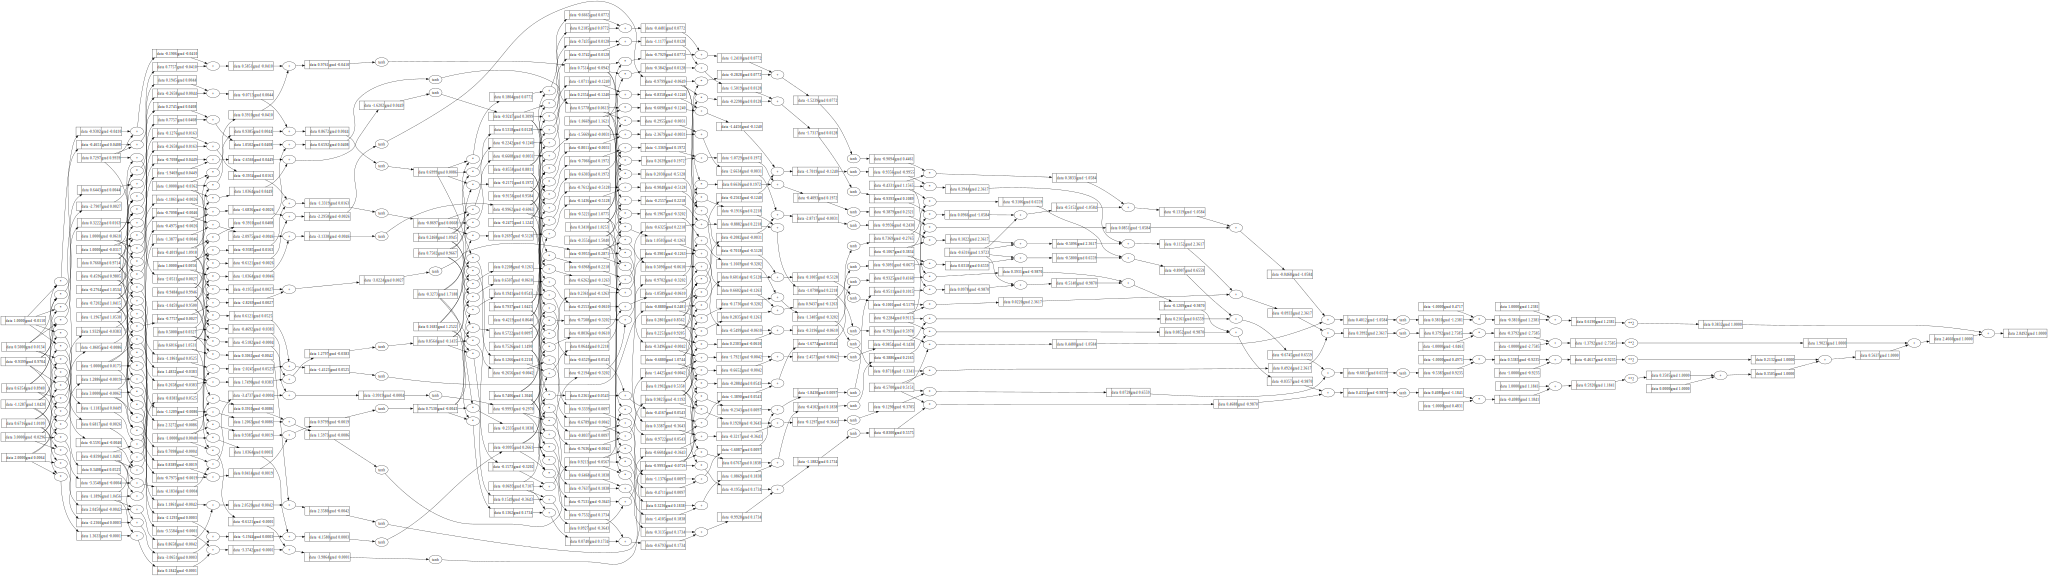

In [127]:
loss.draw_graph()